Mapping of STEM courses to our sectors

In [3]:
# To make relative imports work in notebooks
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


# actual imports
import pandas as pd
import os 

from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas

from src.constants import FIG_DIR
from src.dataLoading import getSalaries

import networkx as nx
import matplotlib.pyplot as plt

import seaborn as sns
import textwrap
from tueplots import bundles


In [4]:
data = getSalaries()

Create a new DataFrame with only the value from the column 'sector' 

In [5]:
# Get the list of columns in the DataFrame
columns_list = data.columns.tolist()

# Let's say you want to rename the column at index 2
columns_list[0] = 'sector'
columns_list[1] = 'year'
columns_list[2] = 'quarter'
columns_list[3] = 'salary'
columns_list[6] = 'salary'

# Assign the modified list of column names back to the DataFrame
data.columns = columns_list


# Create a new DataFrame with only the value from the column 'sector' 
filtered_data = data['sector'].tolist()

# Delete duplicates
unique_list = list(set(filtered_data))

# Filter out NaN values
sector_list = [x for x in unique_list if not pd.isna(x)]

Show length of new dataframe (number of different sectors in our economy) and show the first 5 sectors

In [6]:
print(len(sector_list))

# Print the first five elements
print(sector_list[:5])

4759
['7912', '7123', '9825', '4849', '6897']


If needed, save list as pdf file

In [7]:
# Create a PDF file
c = canvas.Canvas("sector_list_with_index.pdf", pagesize=letter)
c.drawString(100, 750, "Indexed Sector List:")

# Start the Y coordinate for the first item
y = 730
# Height of the page minus bottom margin
page_height = letter[1] - 72

# Loop through the list and add each item to the PDF with an index
for index, item in enumerate(sector_list, start=1):  # start=1 begins indexing from 1
    c.drawString(100, y, f"{index}. {item}")
    y -= 20  # Decrease Y coordinate to move down the page
    if y < 72:  # Less than the bottom margin
        # Add a new page and reset the Y coordinate
        c.showPage()
        c.drawString(100, page_height, "Indexed Sector List (continued):")
        y = page_height - 20

# Save the PDF file
#c.save()

Visualize the mapping using bipartite graph and save it as pdf.

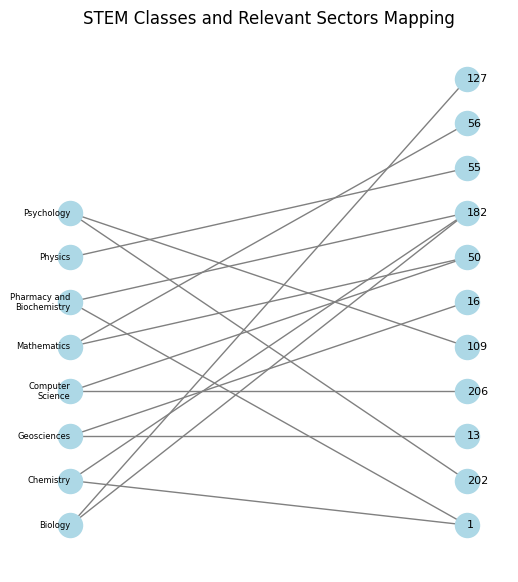

In [8]:
# Create a new graph
B = nx.Graph()

# Add nodes for STEM classes
stem_classes = [
    'Biology', 'Chemistry', 'Geosciences', 'Computer Science', 
    'Mathematics', 'Pharmacy and Biochemistry', 'Physics', 'Psychology'
]

B.add_nodes_from(stem_classes, bipartite=0)

# Add nodes for relevant sectors and corresponding mappings
sectors_mapping = {
    'Biology': [182, 127],
    'Chemistry': [1, 182],
    'Geosciences': [16, 13],
    'Computer Science': [50, 206],
    'Mathematics': [56, 50],
    'Pharmacy and Biochemistry': [182, 1],
    'Physics': [55],
    'Psychology': [109, 202]
}

# Flattening the list of sectors and removing duplicates
all_sectors = list(set([sector for sector_list in sectors_mapping.values() for sector in sector_list]))
B.add_nodes_from(all_sectors, bipartite=1)

# Add edges based on the mappings
for stem_class, sector_list in sectors_mapping.items():
    for sector in sector_list:
        B.add_edge(stem_class, sector)

# Determine the positions for nodes
pos = {node: [0, i] for i, node in enumerate(stem_classes)}
pos.update({node: [1, i] for i, node in enumerate(all_sectors)})

# Create a new figure with a defined size
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust the size as needed

# Draw the graph without labels first
nx.draw(B, pos, with_labels=False, node_color='lightblue', edge_color='gray', ax=ax)

# Define a function to wrap text labels
def wrap_labels(labels, wrap_width):
    return {k: textwrap.fill(v, width=wrap_width) for k, v in labels.items()}

# Wrap class labels and sector labels differently if needed
class_labels = wrap_labels({node: node for node in stem_classes}, wrap_width=15)
sector_labels = wrap_labels({node: str(node) for node in all_sectors}, wrap_width=10)

# Draw custom labels
for label, (x, y) in pos.items():
    if label in class_labels:
        ax.text(x, y, class_labels[label], 
                 horizontalalignment='right' if x == 0 else 'left',
                 verticalalignment='center', fontsize=6)
    else:
        ax.text(x, y, sector_labels[label], 
                 horizontalalignment='right' if x == 0 else 'left',
                 verticalalignment='center', fontsize=8)

# Adjust the plot area to prevent the cutting off of labels
plt.subplots_adjust(left=0.2, right=0.8, top=0.95, bottom=0.05)

ax.set_title("STEM Classes and Relevant Sectors Mapping")

fig.savefig(FIG_DIR + "/STEMFieldsToSectorBipartiteGraph.pdf")
plt.show()

Visualize the mapping using heatmap and save it as pdf.

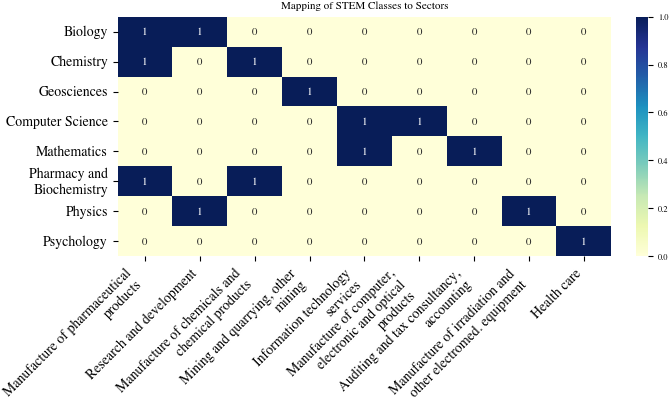

In [9]:

def wrap_labels(labels, width=30):
    return [textwrap.fill(label, width=width) for label in labels]


# Wrap the sector names for readability
sector_names = [
    'Manufacture of pharmaceutical products', 
    'Research and development', 
    'Manufacture of chemicals and chemical products', 
    'Mining and quarrying, other mining', 
    'Information technology services', 
    'Manufacture of computer, electronic and optical products', 
    'Auditing and tax consultancy, accounting', 
    'Manufacture of irradiation and other electromed. equipment', 
    'Health care'
]

# Wrap the sector names for readability
wrapped_sector_names = wrap_labels(sector_names)

# Map the original sector names to the wrapped names
name_mapping = dict(zip(sector_names, wrapped_sector_names))

# Initialize the data with zeros using the wrapped labels
data = {wrapped_name: [0, 0, 0, 0, 0, 0, 0, 0] for wrapped_name in wrapped_sector_names}

# Update the data to reflect the associations
# Biology
data[name_mapping['Manufacture of pharmaceutical products']][0] = 1  
data[name_mapping['Research and development']][0] = 1  

# Chemistry
data[name_mapping['Manufacture of chemicals and chemical products']][1] = 1  
data[name_mapping['Manufacture of pharmaceutical products']][1] = 1  

# Geosciences
data[name_mapping['Mining and quarrying, other mining']][2] = 1  
#data[name_mapping['Ore mining']][2] = 1  

# Computer Science
data[name_mapping['Information technology services']][3] = 1  
data[name_mapping['Manufacture of computer, electronic and optical products']][3] = 1  

# Mathematics
data[name_mapping['Information technology services']][4] = 1  
data[name_mapping['Auditing and tax consultancy, accounting']][4] = 1  

# Pharmacy and Biochemistry
data[name_mapping['Manufacture of chemicals and chemical products']][5] = 1  
data[name_mapping['Manufacture of pharmaceutical products']][5] = 1  

# Physics
data[name_mapping['Research and development']][6] = 1  
data[name_mapping['Manufacture of irradiation and other electromed. equipment']][6] = 1  

# Psychology
data[name_mapping['Health care']][7] = 1  
#data[name_mapping['Inpatient psychosocial care facilities, etc.']][7] = 1  

# Create the DataFrame using wrapped labels for columns
df = pd.DataFrame(data, index=[
    'Biology', 'Chemistry', 'Geosciences', 'Computer Science', 
    'Mathematics', 'Pharmacy and Biochemistry', 'Physics', 'Psychology'
])

# Wrap each index label
wrapped_labels = [textwrap.fill(label, width=20) for label in df.index]

# Create the heatmap
plt.rcParams.update(bundles.icml2022(column="full", nrows=1, ncols=1, usetex=True))
sns.heatmap(df, annot=True, cmap="YlGnBu")

# Set the wrapped labels as the y-tick labels
plt.yticks(plt.yticks()[0], wrapped_labels, va="center", rotation=0, fontsize=10)
# Adjust the labels
plt.xticks(rotation=45, ha='right', fontsize=10)

# Customize further as needed
plt.title('Mapping of STEM Classes to Sectors')

plt.savefig(FIG_DIR + "/STEMFieldsToSectorHeatMap.png")
plt.show()